<a href="https://colab.research.google.com/github/RISHIshrivas/Drivers-Behavior-prediction/blob/main/Drivers_behavior_Project_Rishi_shrivas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
from google.colab import files

In [ ]:
uploaded=files.upload()

Saving test_motion_data.csv to test_motion_data (1).csv
Saving train_motion_data.csv to train_motion_data (1).csv


In [ ]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=train0['Timestamp'],y=train0['AccX'],name='AccX'),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=400,title_text="Train AccX")
fig.update_xaxes(title_text="Timestamp")
fig.update_yaxes(title_text="Motion",secondary_y=False)
fig.show()

In [ ]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=test0['Timestamp'],y=test0['AccX'],name='AccX'),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=400,title_text="Test AccX")
fig.update_xaxes(title_text="Timestamp")
fig.update_yaxes(title_text="Motion",secondary_y=False)
fig.show()

In [ ]:
train0=train0.sample(frac=1, random_state=2021)
test0=test0.sample(frac=1, random_state=2021)
display(train0[0:3])
display(test0[0:3])

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
1855,1.111974,-1.553698,-2.449840,0.055131,-0.034208,0.043295,AGGRESSIVE,3582719
2558,-0.245288,-0.623369,-0.214040,0.014813,-0.025045,-0.015348,SLOW,3583176
1198,-0.680338,-0.048300,-3.298533,-0.169057,-0.383012,0.217392,NORMAL,3582276


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
1928,-0.330374,-1.389638,1.784660,0.100793,0.328264,0.041386,SLOW,820085
1855,0.002837,0.419351,-0.304331,0.040317,-0.037034,-0.036194,SLOW,820045
286,-3.260025,-1.804053,-1.095742,0.136223,0.029551,0.020006,AGGRESSIVE,819077


In [ ]:
Name=sorted(train0['Class'].unique().tolist())
print(Name)
print(len(Name))
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))
train0['Class']=train0['Class'].map(normal_mapping)
print(normal_mapping)

['AGGRESSIVE', 'NORMAL', 'SLOW']
3
{'AGGRESSIVE': 0, 'NORMAL': 1, 'SLOW': 2}


In [ ]:
print(train0.columns.tolist())

['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class', 'Timestamp']


In [ ]:
dummies =  pd.get_dummies(train0['Class'])
dummies.columns=Name
display(dummies)
train0=train0.drop(['Class'],axis=1)
train2=pd.concat([train0,dummies],axis=1)
display(train2)

,AGGRESSIVE,NORMAL,SLOW
1855,1,0,0
2558,0,0,1
1198,0,1,0
2242,1,0,0
2011,1,0,0
...,...,...,...
2669,0,0,1
1152,0,1,0
2105,1,0,0
3413,0,0,1


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp,AGGRESSIVE,NORMAL,SLOW
1855,1.111974,-1.553698,-2.449840,0.055131,-0.034208,0.043295,3582719,1,0,0
2558,-0.245288,-0.623369,-0.214040,0.014813,-0.025045,-0.015348,3583176,0,0,1
1198,-0.680338,-0.048300,-3.298533,-0.169057,-0.383012,0.217392,3582276,0,1,0
2242,1.615090,1.346431,0.279828,-0.062156,-0.026878,-0.064828,3582928,1,0,0
2011,0.042554,-2.504619,-1.650434,-0.130572,-0.183870,-0.007407,3582804,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2669,-0.226393,-0.434203,-1.665212,-0.002902,0.028711,0.010919,3583236,0,0,1
1152,-1.580992,-0.766722,1.061868,0.022144,-0.036041,0.073227,3582251,0,1,0
2105,-0.933916,-0.367008,-0.552541,-0.045051,0.133169,0.531376,3582854,1,0,0
3413,1.531926,0.417679,0.006208,-0.030391,0.244957,0.010919,3583667,0,0,1


In [ ]:
tdummies =  pd.get_dummies(test0['Class'])
tdummies.columns=Name
display(tdummies)
test0=test0.drop(['Class'],axis=1)
test2=pd.concat([test0,tdummies],axis=1)
display(test2)

,AGGRESSIVE,NORMAL,SLOW
1928,0,0,1
1855,0,0,1
286,1,0,0
989,0,1,0
971,0,1,0
...,...,...,...
2006,0,0,1
2669,0,0,1
1152,0,1,0
2105,0,0,1


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp,AGGRESSIVE,NORMAL,SLOW
1928,-0.330374,-1.389638,1.784660,0.100793,0.328264,0.041386,820085,0,0,1
1855,0.002837,0.419351,-0.304331,0.040317,-0.037034,-0.036194,820045,0,0,1
286,-3.260025,-1.804053,-1.095742,0.136223,0.029551,0.020006,819077,1,0,0
989,0.200792,1.116078,0.041262,0.015882,-0.172646,0.023671,819534,0,1,0
971,0.126062,1.194308,-0.239080,0.003665,0.074144,-0.033139,819525,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2006,0.193997,0.436718,0.028409,0.087965,-0.059025,-0.006261,820127,0,0,1
2669,0.462322,-0.558948,0.756780,0.014661,0.068035,0.061545,820485,0,0,1
1152,1.620915,0.690096,0.394562,-0.036652,-0.062079,-0.080176,819622,0,1,0
2105,1.276903,1.004819,-0.628493,0.062919,0.206702,-0.025809,820180,0,0,1


In [ ]:
target=Name
trainY=train2[Name]
trainX=train2.drop(Name,axis=1)
testY=test2[Name]
testX=test2.drop(Name,axis=1)

In [ ]:
df_columns = list(trainX.columns)
print(df_columns)

['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Timestamp']


In [ ]:
def create_numeric_feature(input_df):
    use_columns = df_columns
    return input_df[use_columns].copy()

In [ ]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [ ]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [ ]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

  0%|          | 0/1 [00:00<?, ?it/s]

createcreate_numeric_feature  0.002[s]


100%|██████████| 1/1 [00:00<00:00, 379.30it/s]

createcreate_numeric_feature  0.002[s]


In [ ]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv,
             params: dict=None,
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [ ]:
params = {
    'objective': 'rmse',
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5,
    'n_estimators': 10000,
    'colsample_bytree': .5,
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain',
    'random_state': 71,
    'num_leaves': 62
}

In [ ]:
y = trainY
print(y.shape)
print(type(y))

(3644, 3)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
ydf=pd.DataFrame(y)
ydf

,AGGRESSIVE,NORMAL,SLOW
1855,1,0,0
2558,0,0,1
1198,0,1,0
2242,1,0,0
2011,1,0,0
...,...,...,...
2669,0,0,1
1152,0,1,0
2105,1,0,0
3413,0,0,1


Training until validation scores don't improve for 100 rounds.


<ipython-input-16-ac7077da9ee2>:12: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Early stopping, best iteration is:
[128]	valid_0's rmse: 0.0666713
fit fold=0  0.174[s]
Fold 0 RMSLE: 0.0667

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	valid_0's rmse: 0.041716
fit fold=1  0.155[s]
Fold 1 RMSLE: 0.0417

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.050058
Early stopping, best iteration is:
[500]	valid_0's rmse: 0.050058
fit fold=2  0.436[s]
Fold 2 RMSLE: 0.0501

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	valid_0's rmse: 0.0613873
fit fold=3  0.177[s]
Fold 3 RMSLE: 0.0614

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[279]	valid_0's rmse: 0.0401034
fit fold=4  0.252[s]
Fold 4 RMSLE: 0.0401

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0530
Training until validation scores don't improve for 100 rounds.


<ipython-input-16-ac7077da9ee2>:12: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Early stopping, best iteration is:
[129]	valid_0's rmse: 0.0642012
fit fold=0  0.162[s]
Fold 0 RMSLE: 0.0642

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[378]	valid_0's rmse: 0.0253173
fit fold=1  0.329[s]
Fold 1 RMSLE: 0.0253

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0376869
Early stopping, best iteration is:
[523]	valid_0's rmse: 0.0376287
fit fold=2  0.433[s]
Fold 2 RMSLE: 0.0376

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[196]	valid_0's rmse: 0.0377591
fit fold=3  0.251[s]
Fold 3 RMSLE: 0.0378

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[155]	valid_0's rmse: 0.0369147
fit fold=4  0.173[s]
Fold 4 RMSLE: 0.0369

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0424
Training until validation scores don't improve for 100 rounds.


<ipython-input-16-ac7077da9ee2>:12: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[500]	valid_0's rmse: 0.0199414
[1000]	valid_0's rmse: 0.0193042
[1500]	valid_0's rmse: 0.019091
Early stopping, best iteration is:
[1730]	valid_0's rmse: 0.0190255
fit fold=0  1.231[s]
Fold 0 RMSLE: 0.0190

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0325624
Early stopping, best iteration is:
[441]	valid_0's rmse: 0.0324786
fit fold=1  0.397[s]
Fold 1 RMSLE: 0.0325

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0349434
Early stopping, best iteration is:
[403]	valid_0's rmse: 0.0349249
fit fold=2  0.368[s]
Fold 2 RMSLE: 0.0349

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0452103
[1000]	valid_0's rmse: 0.0448295
Early stopping, best iteration is:
[1256]	valid_0's rmse: 0.0447852
fit fold=3  0.978[s]
Fold 3 RMSLE: 0.0448

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0193736
[1000]	valid_0's rmse: 0.0188931
Early stopping,

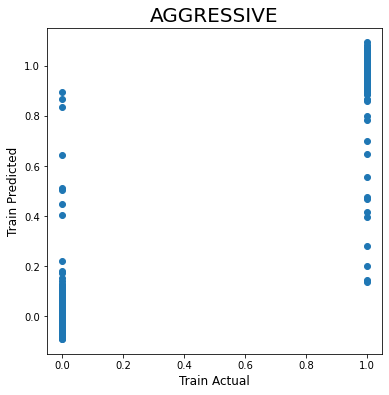

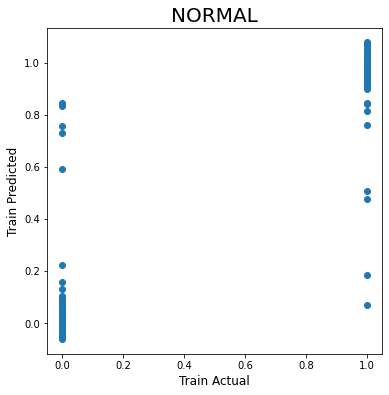

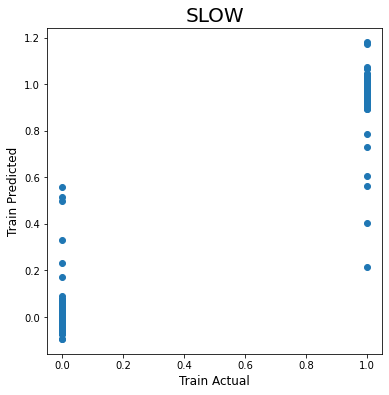

In [ ]:
from sklearn.model_selection import KFold

for i in range(len(Name)):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('Train Actual',fontsize=12)
    ax.set_ylabel('Train Predicted',fontsize=12)
    ax.scatter(y,oof)

In [ ]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h')

    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()

    return fig,ax

<ipython-input-16-ac7077da9ee2>:12: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[128]	valid_0's rmse: 0.0666713
fit fold=0  2.097[s]
Fold 0 RMSLE: 0.0667

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	valid_0's rmse: 0.041716
fit fold=1  0.139[s]
Fold 1 RMSLE: 0.0417

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.050058
Early stopping, best iteration is:
[500]	valid_0's rmse: 0.050058
fit fold=2  0.442[s]
Fold 2 RMSLE: 0.0501

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	valid_0's rmse: 0.0613873
fit fold=3  0.155[s]
Fold 3 RMSLE: 0.0614

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[279]	valid_0's rmse: 0.0401034
fit fold=4  0.256[s]
Fold 4 RMSLE: 0.0401

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0530


<ipython-input-16-ac7077da9ee2>:12: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[129]	valid_0's rmse: 0.0642012
fit fold=0  0.149[s]
Fold 0 RMSLE: 0.0642

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[378]	valid_0's rmse: 0.0253173
fit fold=1  0.330[s]
Fold 1 RMSLE: 0.0253

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0376869
Early stopping, best iteration is:
[523]	valid_0's rmse: 0.0376287
fit fold=2  0.418[s]
Fold 2 RMSLE: 0.0376

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[196]	valid_0's rmse: 0.0377591
fit fold=3  0.190[s]
Fold 3 RMSLE: 0.0378

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[155]	valid_0's rmse: 0.0369147
fit fold=4  0.152[s]
Fold 4 RMSLE: 0.0369

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0424


<ipython-input-16-ac7077da9ee2>:12: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0199414
[1000]	valid_0's rmse: 0.0193042
[1500]	valid_0's rmse: 0.019091
Early stopping, best iteration is:
[1730]	valid_0's rmse: 0.0190255
fit fold=0  1.188[s]
Fold 0 RMSLE: 0.0190

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0325624
Early stopping, best iteration is:
[441]	valid_0's rmse: 0.0324786
fit fold=1  0.384[s]
Fold 1 RMSLE: 0.0325

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0349434
Early stopping, best iteration is:
[403]	valid_0's rmse: 0.0349249
fit fold=2  0.362[s]
Fold 2 RMSLE: 0.0349

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.0452103
[1000]	valid_0's rmse: 0.0448295
Early stopping, best iteration is:
[1256]	valid_0's rmse: 0.0447852
fit fold=3  0.958[s]
Fold 3 RMSLE: 0.0448

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's r

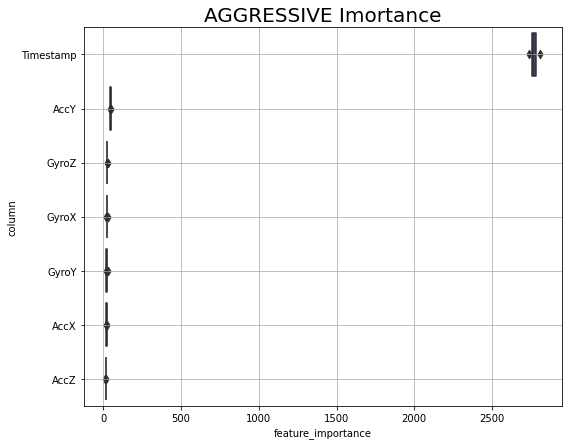

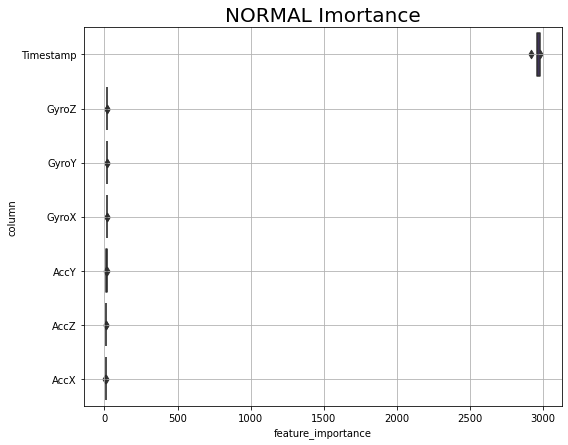

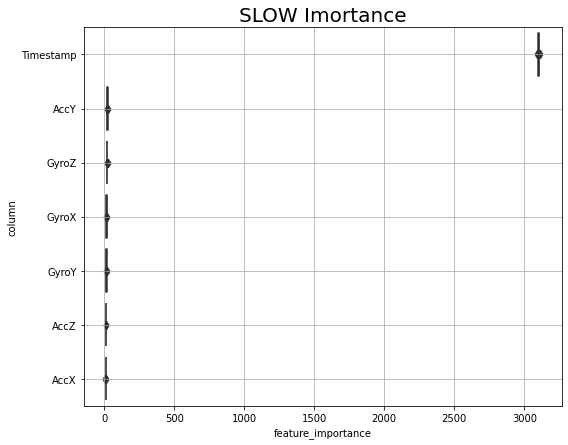

In [ ]:
PREDS=[]
for i in range(len(Name)):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

    pred0 = np.array([model.predict(test_feat_df.values) for model in models])
    PREDS += [pred0[4]]

In [ ]:
TName=['YES','NO']
for i in range(len(Name)):
    PREDi=PREDS[i]
    PREDi2=[]
    for item in PREDi:
        PREDi2+=[int(item)]

    ANSi=testY.iloc[:,i]
    ANSi2=[]
    for item in ANSi:
        ANSi2+=[item]

    print(Name[i])
    print(classification_report(np.array(ANSi2), np.array(PREDi2), target_names=TName, digits=4))

AGGRESSIVE
              precision    recall  f1-score   support

         YES     0.7361    1.0000    0.8480      2270
          NO     0.0000    0.0000    0.0000       814

    accuracy                         0.7361      3084
   macro avg     0.3680    0.5000    0.4240      3084
weighted avg     0.5418    0.7361    0.6241      3084

NORMAL
              precision    recall  f1-score   support

         YES     0.6815    0.8079    0.7393      2087
          NO     0.3426    0.2096    0.2601       997

    accuracy                         0.6145      3084
   macro avg     0.5121    0.5087    0.4997      3084
weighted avg     0.5719    0.6145    0.5844      3084

SLOW
              precision    recall  f1-score   support

         YES     0.5872    1.0000    0.7399      1811
          NO     0.0000    0.0000    0.0000      1273

    accuracy                         0.5872      3084
   macro avg     0.2936    0.5000    0.3700      3084
weighted avg     0.3448    0.5872    0.4345      30

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param